In [6]:
import gpflow

2022-06-09 10:02:00.672090: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-09 10:02:00.672108: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


KeyboardInterrupt: 

In [ ]:
from gpflow import covariances, kernels, likelihoods


In [ ]:
from typing import Optional

import numpy as np
import tensorflow as tf

from gpflow import covariances, kernels, likelihoods
from gpflow.base import Parameter, _cast_to_dtype
from gpflow.config import default_float, default_jitter
from gpflow.expectations import expectation
from gpflow.inducing_variables import InducingPoints
from gpflow.kernels import Kernel
from gpflow.mean_functions import MeanFunction, Zero
from gpflow.probability_distributions import DiagonalGaussian
from gpflow.utilities import positive, to_default_float
from gpflow.utilities.ops import pca_reduce
from gpflow.models.gpr import GPR
from gpflow.models.model import GPModel, MeanAndVariance
from gpflow.models.training_mixins import InputData, InternalDataTrainingLossMixin, OutputData
from gpflow.models.util import data_input_to_tensor, inducingpoint_wrapper
from gpflow.covariances.dispatch import Kuf, Kuu


class LVMOGP_(GPR):
    """
    Latent Variable model where there are both observed and unobserved data.
    """

    def __init__(
        self,
        data: OutputData,
        latent_dim: int,
        X_data_mean: Optional[tf.Tensor] = None,
        kernel: Optional[Kernel] = None,
        mean_function: Optional[MeanFunction] = None,
    ):
        """
        Initialise LVMOGP object. This method only works with a Gaussian likelihood.
        :param data: y data matrix, size N (number of points) x D (dimensions)
        :param latent_dim: the number of latent dimensions (Q)
        :param X_data_mean: latent positions ([N, Q]), for the initialisation of the latent space.
        :param kernel: kernel specification, by default Squared Exponential
        :param mean_function: mean function, by default None.
        """
        if X_data_mean is None:
            X_data_mean = pca_reduce(data, latent_dim)

        num_latent_gps = X_data_mean.shape[1]
        if num_latent_gps != latent_dim:
            msg = "Passed in number of latent {0} does not match initial X {1}."
            raise ValueError(msg.format(latent_dim, num_latent_gps))

        if mean_function is None:
            mean_function = Zero()

        if kernel is None:
            kernel = kernels.SquaredExponential(lengthscales=tf.ones((latent_dim,)))

        if data.shape[1] < num_latent_gps:
            raise ValueError("More latent dimensions than observed.")

        gpr_data = (Parameter(X_data_mean), data_input_to_tensor(data))
        super().__init__(gpr_data, kernel, mean_function=mean_function)


class LVMOGP(GPModel, InternalDataTrainingLossMixin):
    def __init__(
        self,
        data: OutputData,
        X_data: tf.Tensor,
        X_data_fn: tf.Tensor,
        H_data_mean: tf.Tensor,
        H_data_var: tf.Tensor,
        kernel: Kernel,
        num_inducing_variables: Optional[int] = None,
        inducing_variable=None,
        H_prior_mean=None,
        H_prior_var=None,
    ):
        """
        Initialise Bayesian LVMOGP object. This method only works with a Gaussian likelihood.
        :param data: data matrix, size N (number of points) x D (dimensions)
        :param X_data: initial latent positions, size N (number of points) x Q (latent dimensions).
        :param X_data_var: variance of latent positions ([N, Q]), for the initialisation of the latent space.
        :param kernel: kernel specification, by default Squared Exponential
        :param num_inducing_variables: number of inducing points, M
        :param inducing_variable: matrix of inducing points, size M (inducing points) x Q (latent dimensions). By default
            random permutation of X_data_mean.
        :param H_prior_mean: prior mean used in KL term of bound. By default 0. Same size as X_data_mean.
        :param H_prior_var: prior variance used in KL term of bound. By default 1.
        """
        num_data, num_latent_gps = X_data.shape
        num_fns, num_latent_dims = H_data_mean.shape
        super().__init__(kernel, likelihoods.Gaussian(), num_latent_gps=num_latent_gps)
        self.data = data_input_to_tensor(data)

        self.X_data = Parameter(X_data, trainable=False)
        self.X_data_fn = Parameter(X_data_fn, trainable=False)
        self.H_data_mean = Parameter(H_data_mean)
        self.H_data_var = Parameter(H_data_var, transform=positive())

        self.num_fns = num_fns
        self.num_latent_dims = num_latent_dims
        self.num_data = num_data
        self.output_dim = self.data.shape[-1]

        assert X_data.shape[0] == self.data.shape[0], "X mean and Y must be same size."
        assert H_data_mean.shape[0] == H_data_var.shape[0], "H mean and var should be the same length"

        if (inducing_variable is None) == (num_inducing_variables is None):
            raise ValueError(
                "BayesianGPLVM needs exactly one of `inducing_variable` and `num_inducing_variables`"
            )

        if inducing_variable is None:
            # By default we initialize by subset of initial latent points
            # Note that tf.random.shuffle returns a copy, it does not shuffle in-
            X_mean_tilde, X_var_tilde = self.fill_Hs()
            Z = tf.random.shuffle(X_mean_tilde)[:num_inducing_variables]
            inducing_variable = InducingPoints(Z)

        self.inducing_variable = inducingpoint_wrapper(inducing_variable)

        assert X_data.shape[1] == self.num_latent_gps

        # deal with parameters for the prior mean variance of X
        if H_prior_mean is None:
            H_prior_mean = tf.zeros((self.num_fns, self.num_latent_dims), dtype=default_float())
        if H_prior_var is None:
            H_prior_var = tf.ones((self.num_fns, self.num_latent_dims))

        self.H_prior_mean = tf.convert_to_tensor(np.atleast_1d(H_prior_mean), dtype=default_float())
        self.H_prior_var = tf.convert_to_tensor(np.atleast_1d(H_prior_var), dtype=default_float())

        assert self.H_prior_mean.shape[0] == self.num_fns
        assert self.H_prior_mean.shape[1] == self.num_latent_dims
        assert self.H_prior_var.shape[0] == self.num_fns
        assert self.H_prior_var.shape[1] == self.num_latent_dims

    def fill_Hs(self):
        """append Hs to Xs by function number"""

        H_mean_vect = tf.reshape(tf.gather(_cast_to_dtype(self.H_data_mean, dtype=default_float()),
                                      _cast_to_dtype(self.X_data_fn, dtype=tf.int64)),
                                   [self.num_data, self.num_latent_dims])
        H_var_vect = tf.reshape(tf.gather(_cast_to_dtype(self.H_data_var, dtype=default_float()),
                                           _cast_to_dtype(self.X_data_fn, dtype=tf.int64)),
                                   [self.num_data, self.num_latent_dims])

        return tf.concat([self.X_data, H_mean_vect], axis=1),  \
               tf.concat([tf.zeros(self.X_data.shape, dtype=default_float()), H_var_vect], axis=1)

    def maximum_log_likelihood_objective(self) -> tf.Tensor:
        return self.elbo()

    def elbo(self) -> tf.Tensor:
        """
        Construct a tensorflow function to compute the bound on the marginal
        likelihood.
        """
        Y_data = self.data
        mu, var = self.fill_Hs()
        pH = DiagonalGaussian(mu, var)
        # pX = DiagonalGaussian(self.X_data, self.X_data_var)

        num_inducing = self.inducing_variable.num_inducing
        psi0 = tf.reduce_sum(expectation(pH, self.kernel))
        psi1 = expectation(pH, (self.kernel, self.inducing_variable))
        psi2 = tf.reduce_sum(
            expectation(
                pH, (self.kernel, self.inducing_variable), (self.kernel, self.inducing_variable)
            ),
            axis=0,
        )
        cov_uu = covariances.Kuu(self.inducing_variable, self.kernel, jitter=default_jitter())
        L = tf.linalg.cholesky(cov_uu)
        sigma2 = self.likelihood.variance
        sigma = tf.sqrt(sigma2)

        # Compute intermediate matrices
        A = tf.linalg.triangular_solve(L, tf.transpose(psi1), lower=True) / sigma
        tmp = tf.linalg.triangular_solve(L, psi2, lower=True)
        AAT = tf.linalg.triangular_solve(L, tf.transpose(tmp), lower=True) / sigma2
        B = AAT + tf.eye(num_inducing, dtype=default_float())
        # tf.print(B)
        LB = tf.linalg.cholesky(B)
        log_det_B = 2.0 * tf.reduce_sum(tf.math.log(tf.linalg.diag_part(LB)))
        c = tf.linalg.triangular_solve(LB, tf.linalg.matmul(A, Y_data), lower=True) / sigma

        # KL[q(x) || p(x)]
        dH_data_var = (
            self.H_data_var
            if self.H_data_var.shape.ndims == 2
            else tf.linalg.diag_part(self.H_data_var)
        )
        NQ = to_default_float(tf.size(self.H_data_mean))
        D = to_default_float(tf.shape(Y_data)[1])
        KL = -0.5 * tf.reduce_sum(tf.math.log(dH_data_var))
        KL += 0.5 * tf.reduce_sum(tf.math.log(self.H_prior_var))
        KL -= 0.5 * NQ
        KL += 0.5 * tf.reduce_sum(
            (tf.square(self.H_data_mean - self.H_prior_mean) + dH_data_var) / self.H_prior_var
        )

        # compute log marginal bound
        ND = to_default_float(tf.size(Y_data))
        bound = -0.5 * ND * tf.math.log(2 * np.pi * sigma2)
        bound += -0.5 * D * log_det_B
        bound += -0.5 * tf.reduce_sum(tf.square(Y_data)) / sigma2
        bound += 0.5 * tf.reduce_sum(tf.square(c))
        bound += -0.5 * D * (tf.reduce_sum(psi0) / sigma2 - tf.reduce_sum(tf.linalg.diag_part(AAT)))
        bound -= KL
        # tf.print(bound)
        return bound

    def predict_f(self, Xnew: InputData, full_cov=False, full_output_cov=False) -> MeanAndVariance:
        """
        Compute the mean and variance of the latent function at some new points
        Xnew. For a derivation of the terms in here, see the associated SGPR
        notebook.
        """
        Y_data = self.data
        X_data = self.X_data
        X_mean_tilde, X_var_tilde = self.fill_Hs()
        num_inducing = self.inducing_variable.num_inducing
        err = Y_data - self.mean_function(X_data)
        kuf = Kuf(self.inducing_variable, self.kernel, X_mean_tilde)
        kuu = Kuu(self.inducing_variable, self.kernel, jitter=default_jitter())
        Kus = Kuf(self.inducing_variable, self.kernel, Xnew)
        sigma = tf.sqrt(self.likelihood.variance)
        L = tf.linalg.cholesky(kuu)
        A = tf.linalg.triangular_solve(L, kuf, lower=True) / sigma
        B = tf.linalg.matmul(A, A, transpose_b=True) + tf.eye(num_inducing, dtype=default_float())
        LB = tf.linalg.cholesky(B)
        Aerr = tf.linalg.matmul(A, err)
        c = tf.linalg.triangular_solve(LB, Aerr, lower=True) / sigma
        tmp1 = tf.linalg.triangular_solve(L, Kus, lower=True)
        tmp2 = tf.linalg.triangular_solve(LB, tmp1, lower=True)
        mean = tf.linalg.matmul(tmp2, c, transpose_a=True)
        if full_cov:
            var = (
                self.kernel(Xnew)
                + tf.linalg.matmul(tmp2, tmp2, transpose_a=True)
                - tf.linalg.matmul(tmp1, tmp1, transpose_a=True)
            )
            var = tf.tile(var[None, ...], [self.num_latent_gps, 1, 1])  # [P, N, N]
        else:
            var = (
                self.kernel(Xnew, full_cov=False)
                + tf.reduce_sum(tf.square(tmp2), 0)
                - tf.reduce_sum(tf.square(tmp1), 0)
            )
            var = tf.tile(var[:, None], [1, 1]) # self.num_latent_gps
        # tf.print(self.kernel(Xnew, full_cov=False), summarize=-1)
        # tf.print(A, summarize=-1)
        # tf.print(B, summarize=-1)
        return mean + self.mean_function(Xnew), var


    def predict_log_density(self, data: OutputData) -> tf.Tensor:
        raise NotImplementedError

In [146]:
from scipy.stats import norm
def ml_estimate(x):
    """
    Find the log likelihood.

    This doesn't make sense after I have normalised the data.
    """
    score = - np.sum(
            norm.logpdf(x, loc=0, scale=1)
    )
    return score

In [160]:
import numpy as np


x = np.random.normal(0, 1, 1000)
y = np.random.laplace(1, 1, 1000)
# y = x**2 

x = (x - x.mean()) / x.std()
y_meaned = (y - y.mean()) / y.std()

In [161]:
print(ml_estimate(x), ml_estimate(y_meaned))

from scipy.stats import laplace
print( - np.sum(laplace.logpdf(y, 0, 10)))

1418.9385332046727 1418.9385332046727
3128.417953430414


In [24]:

import sys
sys.path.append("/vol/bitbucket/ad6013/Research/gp-causal")
from data.get_data import get_tubingen_pairs_dataset, get_synthetic_dataset
x, y, weight = get_tubingen_pairs_dataset(
    data_path='/vol/bitbucket/ad6013/Research/gp-causal/data/pairs/files'
)
input, output = x[0], y[0]
input = (input - input.mean(axis=0)[:, None]) / input.std(axis=0)[:, None]
output = (output - output.mean(axis=0)[:, None]) / output.std(axis=0)[:, None]

Load cause-effect pairs: 100%|██████████| 100/100 [00:00<00:00, 196.73it/s]


In [25]:
print(ml_estimate(input), ml_estimate(output))

495.2095480884308 495.2095480884308


In [26]:
input.mean()

-1.068868012246569e-16

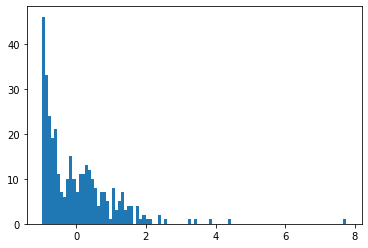

In [19]:
import matplotlib.pyplot as plt
plt.hist(input, bins=100)
plt.show()

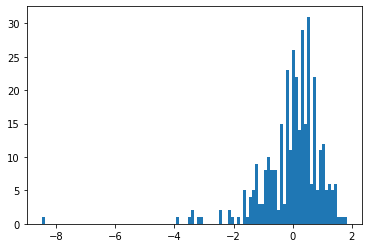

In [20]:
import matplotlib.pyplot as plt
plt.hist(output, bins=100)
plt.show()

In [55]:
import pickle


file = "/vol/bitbucket/ad6013/Research/gp-causal/working_hyper.p"

with open(file, "rb") as f:
    results = pickle.load(f)

In [56]:
results

kern_var = []
prior_noise = []
post_noise = []
for tuples in results:
    kern_var.append(tuples[0])
    prior_noise.append(float(tuples[1]))
    post_noise.append(float(tuples[2]))

In [64]:
max(prior_noise)

0.8396646813844957

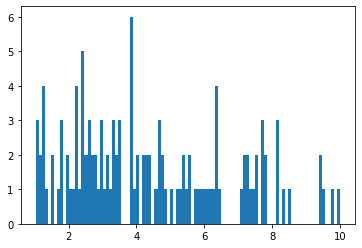

In [58]:
import matplotlib.pyplot as plt

plt.hist(kern_var, bins=100)
plt.show()

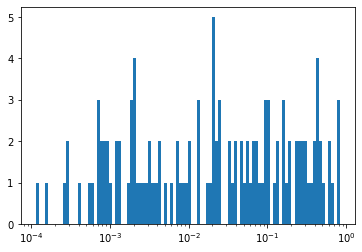

In [63]:
import numpy as np
hist, bins, _ = plt.hist(prior_noise, bins=100)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.clf()
plt.hist(prior_noise, bins=logbins)
plt.xscale('log')
plt.show()

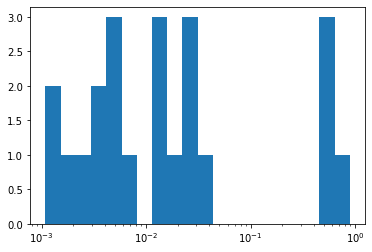

In [54]:
import numpy as np
hist, bins, _ = plt.hist(post_noise, bins=20)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.clf()
plt.hist(post_noise, bins=logbins)
plt.xscale('log')
plt.show()